In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.graphics.tsaplots import plot_acf



%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/workshop_files/GlobalLandTemperaturesByState.csv")

In [5]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [6]:
df.duplicated().sum()

0

In [7]:
df.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
State                             object
Country                           object
dtype: object

In [8]:
df.shape

(645675, 5)

In [9]:
df.isnull().sum()

dt                                   0
AverageTemperature               25648
AverageTemperatureUncertainty    25648
State                                0
Country                              0
dtype: int64

In [10]:
# Drop null rows
# axis = 0 because we are droping rows
df = df.dropna(how = 'any', axis = 0)

In [11]:
df.shape

(620027, 5)

In [12]:
df.rename(columns={'dt': 'Date', 'AverageTemperature': 'Avg_temp', 'AverageTemperatureUncertainty': 'confidence_interval_temp'}, inplace=True)
df.head()

,Date,Avg_temp,confidence_interval_temp,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [13]:
df['Date'].dtype

dtype('O')

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df.index

DatetimeIndex(['1855-05-01', '1855-06-01', '1855-07-01', '1855-08-01',
               '1855-09-01', '1855-10-01', '1855-11-01', '1855-12-01',
               '1856-01-01', '1856-02-01',
               ...
               '2012-11-01', '2012-12-01', '2013-01-01', '2013-02-01',
               '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-01',
               '2013-07-01', '2013-08-01'],
              dtype='datetime64[ns]', name='Date', length=620027, freq=None)

In [15]:
df.describe()

,Avg_temp,confidence_interval_temp
count,620027.000000,620027.000000
mean,8.993111,1.287647
std,13.772150,1.360392
min,-45.389000,0.036000
25%,-0.693000,0.316000
50%,11.199000,0.656000
75%,19.899000,1.850000
max,36.339000,12.646000


In [16]:
df['Year'] = df.index.year
df.head()

,Avg_temp,confidence_interval_temp,State,Country,Year
Date,,,,,
1855-05-01,25.544,1.171,Acre,Brazil,1855
1855-06-01,24.228,1.103,Acre,Brazil,1855
1855-07-01,24.371,1.044,Acre,Brazil,1855
1855-08-01,25.427,1.073,Acre,Brazil,1855
1855-09-01,25.675,1.014,Acre,Brazil,1855


In [17]:
latest_df = df.loc['1980':'2013']
latest_df.head()

,Avg_temp,confidence_interval_temp,State,Country,Year
Date,,,,,
1980-01-01,26.652,0.190,Acre,Brazil,1980
1980-02-01,26.495,0.495,Acre,Brazil,1980
1980-03-01,26.270,0.236,Acre,Brazil,1980
1980-04-01,26.430,0.201,Acre,Brazil,1980
1980-05-01,25.802,0.882,Acre,Brazil,1980


In [18]:
latest_df[['Country', 'Avg_temp']].groupby(['Country']).mean().sort_values('Avg_temp')

,Avg_temp
Country,
Canada,-0.681256
Russia,2.432833
United States,11.516373
China,12.150210
Australia,18.447621
India,22.871669
Brazil,24.537580


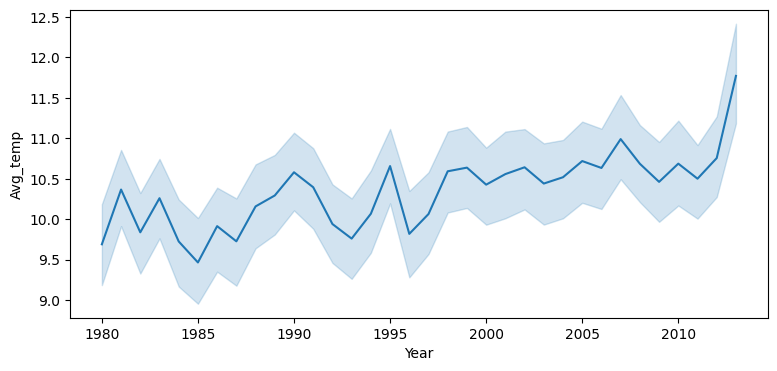

In [19]:
plt.figure(figsize=(9,4))
sns.lineplot(x="Year", y="Avg_temp", data=latest_df)
plt.show()

In [21]:
resample_df=latest_df[['Avg_temp']].resample('A').mean()

In [22]:
resample_df.head()

,Avg_temp
Date,
1980-12-31,9.689856
1981-12-31,10.366578
1982-12-31,9.837958
1983-12-31,10.259516
1984-12-31,9.724950


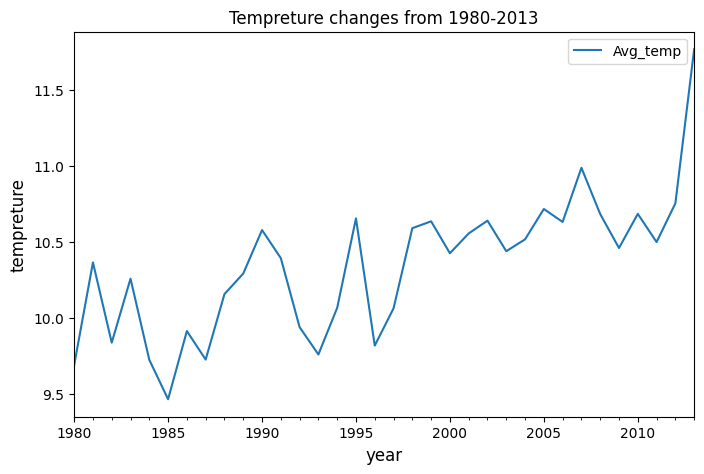

In [26]:
resample_df.plot(title='Tempreture changes from 1980-2013',figsize=(8,5))
plt.ylabel('tempreture',fontsize=12)
plt.xlabel('year',fontsize=12)
plt.legend()


In [29]:
from statsmodels.tsa.stattools import adfuller

print("Dickey Fuller Test Results:")
test_df= adfuller(resample_df.iloc[ :,0].values, autolag='AIC')
df_output= pd.Series(test_df[0:4], index=['Test Statistic','p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in test_df[4].items():
         df_output['Critical Valve (%s)'%key]=value
print(df_output)



Dickey Fuller Test Results:
Test Statistic                 -0.728209
p-value                         0.839307
Lags Used                       2.000000
Number of Observations Used    31.000000
Critical Valve (1%)            -3.661429
Critical Valve (5%)            -2.960525
Critical Valve (10%)           -2.619319
dtype: float64


In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(resample_df)  # 'freq' should match the frequency of your data

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

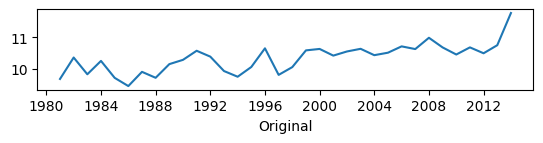

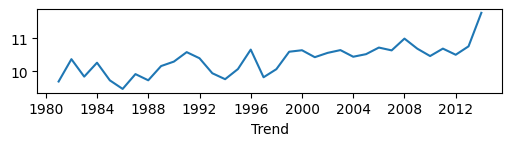

<Figure size 600x500 with 0 Axes>

In [42]:
plt.subplot(411)
plt.plot(resample_df)
plt.xlabel('Original')
plt.figure(figsize=(6,5))

plt.subplot(412)
plt.plot(trend)
plt.xlabel('Trend')
plt.figure(figsize=(6,5))



plt.tight_layout()


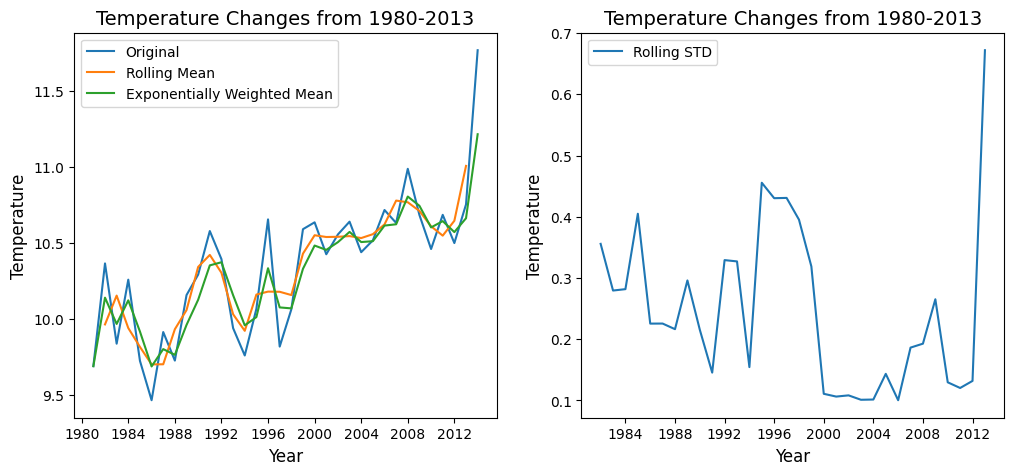

In [44]:
rol_mean =resample_df.rolling(window=3, center=True).mean()
#Exponentially weighted mean
ewm= resample_df.ewm(span=3).mean()
#Rolling standard deviation
rol_std =resample_df.rolling(window=3, center=True).std()
#Creating subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
#Temperature graph with rolling mean and exponentially weighted mean
ax1.plot(resample_df,label='Original')
ax1.plot(rol_mean, label='Rolling Mean')
ax1.plot(ewm, label='Exponentially Weighted Mean')
ax1.set_title('Temperature Changes from 1980-2013', fontsize=14)
ax1.set_ylabel('Temperature', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.legend()
#Temperature graph with rolling STD
ax2.plot(rol_std, label='Rolling STD')
ax2.set_title('Temperature Changes from 1980-2013', fontsize=14)
ax2.set_ylabel('Temperature', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.legend()

In [47]:
rol_mean.dropna(inplace=True)
ewm.dropna(inplace=True)
print("Dickey Fuller Test for rolling means:")
df_test= adfuller(rol_mean.iloc[ :,0].values, autolag='AIC')
df_output= pd.Series(df_test[0:4], index=['Test Statistic','p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in df_test[4].items():
         df_output['Critical Valve (%s)'%key]=value
print(df_output)
print('')
print("Dickey Fuller Test for exponential weighted mean:")
df_test= adfuller(ewm.iloc[ :,0].values, autolag='AIC')
df_output= pd.Series(df_test[0:4], index=['Test Statistic','p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in df_test[4].items():
         df_output['Critical Valve (%s)'%key]=value
print(df_output)




Dickey Fuller Test for rolling means:
Test Statistic                  0.275101
p-value                         0.976173
Lags Used                       8.000000
Number of Observations Used    23.000000
Critical Valve (1%)            -3.752928
Critical Valve (5%)            -2.998500
Critical Valve (10%)           -2.638967
dtype: float64

Dickey Fuller Test for exponential weighted mean:
Test Statistic                 -0.338693
p-value                         0.919843
Lags Used                       2.000000
Number of Observations Used    31.000000
Critical Valve (1%)            -3.661429
Critical Valve (5%)            -2.960525
Critical Valve (10%)           -2.619319
dtype: float64


In [48]:
diff_rol_mean =resample_df -rol_mean
diff_rol_mean.dropna(inplace=True)
diff_rol_mean.head()


,Avg_temp
Date,
1981-12-31,0.401781
1982-12-31,-0.316726
1983-12-31,0.318708
1984-12-31,-0.091684
1985-12-31,-0.236199


In [49]:
diff_ewm =resample_df - ewm
diff_ewm.dropna(inplace=True)
diff_ewm.head()

,Avg_temp
Date,
1980-12-31,0.000000
1981-12-31,0.225574
1982-12-31,-0.129877
1983-12-31,0.136118
1984-12-31,-0.192797


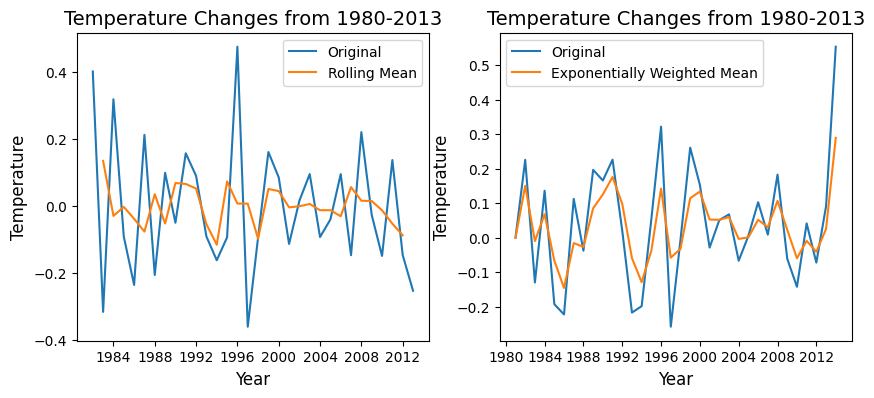

In [50]:
df_rol_mean_diff = diff_rol_mean.rolling(window=3, center=True).mean()
df_ewm_diff= diff_ewm.ewm(span=3).mean()
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(10,4))
ax1.plot(diff_rol_mean, label='Original')
ax1.plot(df_rol_mean_diff, label='Rolling Mean')
ax1.set_title('Temperature Changes from 1980-2013', fontsize=14)
ax1.set_ylabel('Temperature', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.legend()
ax2.plot(diff_ewm, label='Original')
ax2.plot(df_ewm_diff,label='Exponentially Weighted Mean')
ax2.set_title('Temperature Changes from 1980-2013', fontsize=14)
ax2.set_ylabel('Temperature', fontsize=12)
ax2.set_xlabel('Year', fontsize=12)
ax2.legend()

In [51]:
print("Dickey Fuller Test for  difference between original and rolling means:")
dftest= adfuller(diff_rol_mean.iloc[ :,0].values, autolag='AIC')
dfoutput= pd.Series(dftest[0:4], index=['Test Statistic','p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
         df_output['Critical Valve (%s)'%key]=value
print(dfoutput)
print('')
print("Dickey Fuller Test for difference between original and exponential weighted mean:")
dftest= adfuller(diff_ewm.iloc[ :,0].values, autolag='AIC')
dfoutput= pd.Series(dftest[0:4], index=['Test Statistic','p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
         df_output['Critical Valve (%s)'%key]=value
print(dfoutput)

Dickey Fuller Test for  difference between original and rolling means:
Test Statistic                -7.007710e+00
p-value                        7.051586e-10
Lags Used                      1.000000e+00
Number of Observations Used    3.000000e+01
dtype: float64

Dickey Fuller Test for difference between original and exponential weighted mean:
Test Statistic                 -4.297446
p-value                         0.000449
Lags Used                       1.000000
Number of Observations Used    32.000000
dtype: float64


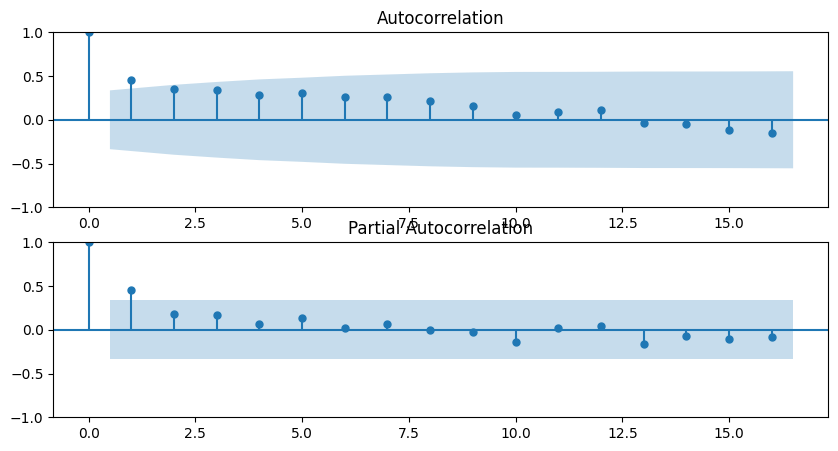

In [52]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
#Plotting the autocorrelation and partial autocorrelation graphs
pyplot.figure(figsize=(10,5))
pyplot.subplot(211)
plot_acf(resample_df, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(resample_df ,ax=pyplot.gca())
pyplot.show()